<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: Ольга Дайховская

# <center> Домашнее задание № 4. Часть 2
## <center>  Прогнозирование популярности статей на TechMedia с помощью линейных моделей

**В задании Вам предлагается разобраться с тем, как работает TfidfVectorizer и DictVectorizer, затем обучить и настроить модель линейной регрессии Ridge на данных о публикациях на Хабрахабре. Пройдя все шаги, вы сможете получить бейзлайн для [соревнования](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm). 
Ответьте на все вопросы в этой тетрадке и заполните ответы в [гугл-форме](https://docs.google.com/forms/d/e/1FAIpQLSd8E7naU38ikc9-rd31KeVfez3emCo4Ok1WrpQTr-XCDelRiw/viewform).**

**Описание соревнования**

Предскажите, как много звездочек наберет статья, зная только ее текст и время публикации

Необходимо предсказать популярность поста на Хабре по содержанию и времени публикации. Как известно, пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать, что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

**Приступим:** импортируем необходимые библиотеки и скачаем данные

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

#В зависимости от версии sklearn
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import numpy as np
import scipy

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
train_df = pd.read_csv('data/howpop_train.csv')
test_df  = pd.read_csv('data/howpop_test.csv')

In [ ]:
train_df.head(1).T

In [ ]:
train_df.shape, test_df.shape

Убедимся, что данные отсортированы по признаку `published`

In [ ]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

**Чтобы ответить на вопросы 1 и 2, можно использовать [pandas.DataFrame.corr()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html), [pandas.to_datetime()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) и [pandas.Series.value_counts()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html)**

<font color='red'>Вопрос 1.</font> Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)
- да
- нет
- не знаю

In [ ]:
categorical_columns_train = [c for c in train_df.columns if train_df[c].dtype.name == 'object']

In [ ]:
numerical_columns_train = [c for c in train_df.columns if train_df[c].dtype.name != 'object']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib
train_df[numerical_columns_train].corr()
#sns.heatmap(corr_matrix)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.matshow(train_df[numerical_columns_train].corr(), vmin=-1, vmax=1)
plt.yticks(range(train_df[numerical_columns_train].shape[1]), train_df[numerical_columns_train].columns)
plt.xticks(range(train_df[numerical_columns_train].shape[1]), train_df[numerical_columns_train].columns, rotation=45, ha="left" )
plt.show()

In [ ]:
corr_matrix = train_df.corr()
sns.heatmap(corr_matrix)

<font color='red'>Вопрос 2.</font> В каком году было больше всего публикаций? (Рассматриваем train_df)
- 2014
- 2015
- 2016
- 2017

In [ ]:
train_df.head()

In [ ]:
s = '2013 07 6'
s[0:4]

In [3]:
def ti(x):
    return x[0:4]

In [4]:
train_df['year'] = train_df['published'].apply(ti)
train_df['year'] = train_df['year'].apply(int)
train_df['year'].unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

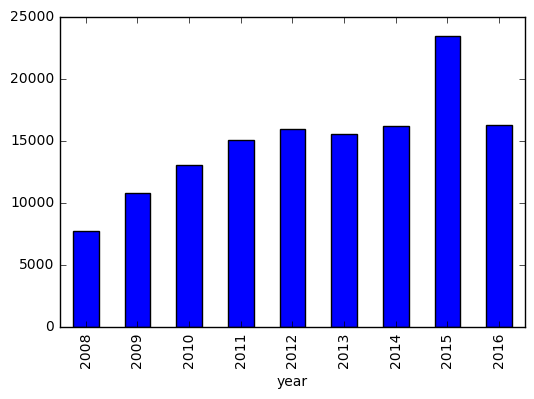

In [5]:
train_df.groupby(['year'])['post_id'].count().plot(kind = 'bar')
plt.show()

## Разбиение на train/valid
Используем только признаки 'author', 'flow', 'domain' и 'title'

In [6]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [7]:
len(train_df),train_size

(134137, 93895)

In [8]:
X, y = train_df.ix[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.ix[:, features]

In [9]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

## Применение TfidfVectorizer

**TF-IDF** (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции. [Подробнее в источнике](https://ru.wikipedia.org/wiki/TF-IDF)

TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.

**Основные параметры TfidfVectorizer в sklearn:**
- **min_df** - при построении словаря слова, которые встречаются *реже*, чем указанное значение, игнорируются
- **max_df** - при построении словаря слова, которые встречаются *чаще*, чем указанное значение, игнорируются
- **analyzer** - определяет, строятся ли признаки по словам или по символам (буквам)
- **ngram_range** - определяет, формируются ли признаки только из отдельных слов или из нескольких слов (в случае с analyzer='char' задает количество символов). Например, если указать analyzer='word' и ngram_range=(1,3),то признаки будут формироваться из отдельных слов, из пар слов и из троек слов.
- **stop_words** - слова, которые игнорируются при построении матрицы

Более подробно с параметрами можно ознакомиться в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

**Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(min_df=3, max_df=0.3 и ngram_range=(1, 3))
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)

<font color='red'>Вопрос 3.</font> Какой размер у полученного словаря?
- 43789
- 50624
- 93895
- 74378

In [13]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3 , ngram_range=(1, 3))

X_train_title = vectorizer_title.fit_transform(X_train['title'])
#X_valid_title = #и тут тоже
#X_test_title = #и тут

In [14]:
X_valid_title = vectorizer_title.transform(X_valid['title'])
X_test_title = vectorizer_title.transform(X_test['title'])

In [19]:
len(X_train)

93895

In [18]:
X_train_title.shape

(93895, 50624)

In [20]:
#Можно посмотреть словарь в виде {'термин': индекс признака,...}
vectorizer_title.vocabulary_

{'для mozilla': 18960,
 'ext net': 4080,
 'прототипы': 39709,
 'новая бизнес модель': 31397,
 'на хабр': 30086,
 'кто ответе': 26451,
 'ir': 6014,
 'вызов': 16844,
 'lxbox': 6832,
 'одного электровелосипеда': 32906,
 'писать': 35235,
 '157': 383,
 'небольшом': 30959,
 'play edition': 8751,
 'следующей неделе': 43426,
 'по образцу': 35861,
 'idea': 5580,
 'как мы': 24131,
 'закрытие': 21370,
 'ключевое': 25063,
 'нашему': 30737,
 'универсальное': 47271,
 'band': 2106,
 'диапазона': 18619,
 'developers': 3424,
 'privacy': 8910,
 'отпечатанного': 34176,
 'группы defcon russia': 17902,
 'про устройство': 38880,
 'soon': 10261,
 'приватность или': 38301,
 'humble indie bundle': 5473,
 'сиклум net': 43000,
 'чемпионата': 49210,
 'игровой движок часть': 22127,
 'из социальных': 22447,
 'backup replication': 2089,
 'что ещё можно': 49506,
 'себя от': 42532,
 'persia': 8532,
 'управлять': 47410,
 'три способа': 46715,
 'первый ноутбук': 34815,
 'опасный': 33127,
 'английски': 13130,
 'zx spectr

In [21]:
len(vectorizer_title.vocabulary_)

50624

<font color='red'>Вопрос 4.</font> Какой индекс у слова 'python'?
- 1
- 10
- 9065
- 15679

In [24]:
vectorizer_title.vocabulary_['python']

9065

**Инициализируйте TfidfVectorizer, указав analyzer='char'.<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 5.</font> Какой размер у полученного словаря?
- 218
- 510
- 125
- 981

In [ ]:
vectorizer_title_ch = #ваш код здесь

X_train_title_ch = #...
X_valid_title_ch = #...
X_test_title_ch = #...

In [ ]:
#Здесь так же можно посмотреть словарь
#Заметьте насколько отличаются словари для TfidfVectorizer с analyzer='word' и analyzer='char'
vectorizer_title_ch.vocabulary_

In [28]:
vectorizer_title = TfidfVectorizer(analyzer='char')

X_train_title = vectorizer_title.fit_transform(X_train['title'])
#X_valid_title = #и тут тоже
#X_test_title = #и тут
X_valid_title = vectorizer_title.transform(X_valid['title'])
X_test_title = vectorizer_title.transform(X_test['title'])

In [29]:
X_train_title.shape

(93895, 218)

In [30]:
len(vectorizer_title.vocabulary_)

218

## Работа с категориальными признаками

Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать DictVectorizer из sklearn.

In [ ]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

Рассмотрим как он работает на примере первых пяти строк

In [ ]:
#сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

In [ ]:
#Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
#а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

In [ ]:
#В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
#поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

In [ ]:
#В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

In [ ]:
#Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

In [ ]:
#В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
#Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

Посмотрим сколько уникальных значений в каждой колонке.<br />
Суммарно их 9 - столько же, сколько и колонок. Это объясняется тем, что для категориальных признаков со строковыми значениями DictVectorizer делает кодирование бинарными признаками - каждому уникальному значению признака соответствует один новый бинарный признак, который равен 1 только в том случае, если в исходной матрице этот признак принимает значение, которому соответствует эта колонка новой матрицы.

In [ ]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

Также можно посмотреть что означает каждая колонка полученной матрицы

In [ ]:
#например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

**Инициализируйте DictVectorizer с параметрами по умолчанию.<br />
Примените метод fit_transform к признакам 'author', 'flow', 'domain' X_train и метод transform к тем же признакам X_valid и X_test**

In [ ]:
vectorizer_feats = #ваш код здесь

X_train_feats = #...
X_valid_feats = #...
X_test_feats = #...

In [ ]:
X_train_feats.shape

Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [ ]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

## Обучение модели

Далее будем использовать Ridge, линейную модель с l2-регуляризацией.
[Документация](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

Основной параметр Ridge - **alpha, коэффициент регуляризации**. Регуляризация используется для улучшения обобщающей способности модели - прибавляя к функционалу потерь сумму квадратов весов, умноженную на коэффициент регуляризации (та самая alpha), мы штрафуем модель за слишком большие значения весов и не позволяем ей переобучаться. Чем больше этот коээфициент, тем сильнее эффект.

**Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1**

**Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.**

<font color='red'>Вопрос 6.</font> Выберите верные утверждения:
- обе модели показывают одинаковый результат (среднеквадратичная ошибка отличается не больше чем на тысячные), регуляризация ничего не меняет
- при alpha=0.1 модель переобучается
- среднеквадратичная ошибка первой модели на тесте меньше
- при alpha=1.0 у модели обощающая способность лучше, чем у при alpha=0.1

In [ ]:
%%time
model1 = #ваш код здесь
#здесь тоже ваш код

In [ ]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds1))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds1))

In [ ]:
%%time
model2 = #ваш код здесь
#здесь тоже ваш код

In [ ]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds2))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds2))

## Baseline

**Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.**

In [ ]:
%%time
model = #ваш код здесь

#обучите модель на всех данных

test_preds = model.predict(X_test_new)

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv', index_col='url')

In [ ]:
sample_submission.head()

In [ ]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds
ridge_submission.to_csv('ridge_baseline.csv') #а вот и бейзлайн